<a href="https://colab.research.google.com/github/satomun/SIGNATE_mynavi2019/blob/master/SIGNATE%E5%BC%95%E8%B6%8A%E3%81%97%E9%9C%80%E8%A6%81%E4%BA%88%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

評価関数：MAE（Mean Absolute Error）

train:2010-07-01から2016-03-31までの引越しデータ(2101, 6)

test :2016-04-01から2017-03-31までの引越しデータ(365, 5)

closeが１ならｙは０である

時系列CV注意、かぐる本、祝日

In [72]:
# !pip install catboost


In [103]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import math
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import TimeSeriesSplit
from fbprophet import Prophet
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings("ignore")

train = pd.read_csv("train_hikkoshi.csv")
test  = pd.read_csv("test_hikkoshi.csv")
cal = pd.read_csv("cal.csv")


In [104]:
cal['datetime'] = pd.to_datetime(cal['日付'])
del cal["日付"]

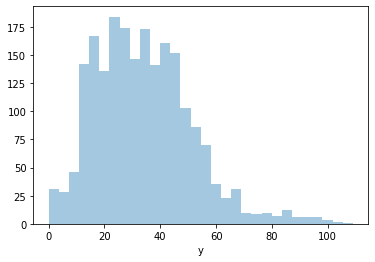

In [106]:

            # 実験スペース
# train[["datetime","y"]][490:].head(30)
# jikkenn = train[["datetime","close","y"]]
# jikkenn[jikkenn["y"]==0]

# jikkenn = test[["datetime","close"]]
# jikkenn[jikkenn["close"]==1]

#0を消して学習してもLBやや悪化
# zero_list = train[train["y"]==0].index.to_list()
# train = train[train["y"]!=0]
sns.distplot(train["y"], kde=False,)


In [76]:
def preprocessing(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['year'] = df["datetime"].dt.year
    df['month'] = df["datetime"].dt.month
    df['day'] = df["datetime"].dt.day
    df["wed"] = df["datetime"].dt.dayofweek
    # df['year*wed'] = df['year']*df['wed'] #CV悪化
    df["price_am"] = df["price_am"]+2
    df["price_pm"] = df["price_pm"]+2
    df['pm+am'] = df['price_pm']+df['price_am']
    df['pm-am'] = df['price_pm']-df['price_am']
    df['pm/am'] = df['price_pm']/df['price_am']
    df["am*pm"] = df["price_am"]*df["price_pm"]
    df["cli*am"] = df["client"]*df["price_am"]
    df["cli*pm"] = df["client"]*df["price_pm"]
    # df['oneday_before_am'] = df['price_am'].shift(1) #cvdown
    # df['oneday_before_pm'] = df['price_pm'].shift(1) #cvdown
    # df['rel_am'] = df['price_am'].rolling(2).sum()
    # df['rel_pm'] = df['price_pm'].rolling(2).sum()
    df['rel_am_mean'] = df['price_am'].rolling(5).mean() #cvup
    df['rel_pm_mean'] = df['price_pm'].rolling(5).mean() #cvup
    # df['rel_am_mean'] = df['price_am'].rolling(30).mean() #cvdown
    # df['rel_pm_mean'] = df['price_pm'].rolling(30).mean() #cvdown
    # df['rel_3cli'] = df['client'].rolling(5).sum()
    # df['rel_3clo'] = df['close'].rolling(5).sum()
    df["holy"] = df["wed"]
    df["holy"] = df["wed"].replace([0,1,2,3,4],0).replace([5,6],1)
    # df['day2'] = pd.cut(df['day'], bins=[0,1,2,19,25,31])
    # df=pd.get_dummies(df, columns=['day2'],drop_first=True)
    # del df['day'] #CV悪化
    # df["day"] = df["day"].replace(31,30)#CV悪化
    # df["1flg"] = 0#CV悪化
    # df["1flg"] = df["1flg"].mask(df["day"]==1,1)#CV悪化
    # df["1flg"] = df["1flg"].mask(df["day"]==29,1)#CV悪化
    # df["1flg"] = df["1flg"].mask(df["day"]==30,1)#CV悪化

    return df

train = preprocessing(train)
test  = preprocessing(test)


In [77]:
# target encording
# train["t_year"] = train.groupby("year")["y"].transform("mean")
# test["t_year"] = test["year"].map(train.groupby("year")["y"].mean())
train["t_month"] = train.groupby("month")["y"].transform("mean")
test["t_month"] = test["month"].map(train.groupby("month")["y"].mean())
train["t_day"] = train.groupby("day")["y"].transform("mean")
test["t_day"] = test["day"].map(train.groupby("day")["y"].mean())
train["t_am"] = train.groupby("price_am")["y"].transform("mean")
test["t_am"] = test["price_am"].map(train.groupby("price_am")["y"].mean())
train["t_pm"] = train.groupby("price_pm")["y"].transform("mean")
test["t_pm"] = test["price_pm"].map(train.groupby("price_pm")["y"].mean())
train["t_wed"] = train.groupby("wed")["y"].transform("mean")
test["t_wed"] = test["wed"].map(train.groupby("wed")["y"].mean())
# train["t_cli"] = train.groupby("client")["y"].transform("mean")
# test["t_cli"] = test["client"].map(train.groupby("client")["y"].mean())
# train["t_clo"] = train.groupby("close")["y"].transform("mean")
# test["t_clo"] = test["close"].map(train.groupby("close")["y"].mean())

In [78]:
# 単純に祝日入れるだけだとLBとCV両方悪化した
# train = pd.merge(train,cal, on="datetime", how="left")
# test = pd.merge(test,cal, on="datetime", how="left")
# train["shukujitu"] = train["shukujitu"].fillna(0)
# test["shukujitu"] = test["shukujitu"].fillna(0)
# train.tail(10)


In [79]:
# train["shukujitu"]=train["shukujitu"].apply(lambda x : 1 if x!=0 else 0)
# test["shukujitu"]=test["shukujitu"].apply(lambda x : 1 if x!=0 else 0)
train.tail(30)

,datetime,y,client,close,price_am,price_pm,year,month,day,wed,pm+am,pm-am,pm/am,am*pm,cli*am,cli*pm,rel_am_mean,rel_pm_mean,holy,t_month,t_day,t_am,t_pm,t_wed
2071,2016-03-02,59,1,0,3,3,2016,3,2,2,6,0,1.000000,9,3,3,4.0,3.4,0,58.005376,33.746032,39.141397,41.989919,30.345763
2072,2016-03-03,53,1,0,2,2,2016,3,3,3,4,0,1.000000,4,2,2,3.4,3.0,0,58.005376,32.555556,28.531780,30.387395,30.962963
2073,2016-03-04,62,1,0,3,2,2016,3,4,4,5,-1,0.666667,6,3,2,3.2,2.6,0,58.005376,30.014493,39.141397,30.387395,34.773649
2074,2016-03-05,67,1,0,4,3,2016,3,5,5,7,-1,0.750000,12,4,3,3.2,2.6,1,58.005376,28.753623,47.312000,41.989919,41.847973
2075,2016-03-06,59,1,0,3,3,2016,3,6,6,6,0,1.000000,9,3,3,3.0,2.6,1,58.005376,27.811594,39.141397,41.989919,38.847973
2076,2016-03-07,53,1,0,3,3,2016,3,7,0,6,0,1.000000,9,3,3,3.0,2.6,0,58.005376,27.985507,39.141397,41.989919,34.283784
2077,2016-03-08,46,0,0,3,2,2016,3,8,1,5,-1,0.666667,6,0,0,3.2,2.6,0,58.005376,27.130435,39.141397,30.387395,30.952703
2078,2016-03-09,56,1,0,2,2,2016,3,9,2,4,0,1.000000,4,2,2,3.0,2.6,0,58.005376,26.724638,28.531780,30.387395,30.345763
2079,2016-03-10,60,1,0,2,2,2016,3,10,3,4,0,1.000000,4,2,2,2.6,2.4,0,58.005376,30.173913,28.531780,30.387395,30.962963
2080,2016-03-11,66,0,0,3,2,2016,3,11,4,5,-1,0.666667,6,0,0,2.6,2.2,0,58.005376,28.246377,39.141397,30.387395,34.773649


In [80]:
test.tail(30)

,datetime,client,close,price_am,price_pm,year,month,day,wed,pm+am,pm-am,pm/am,am*pm,cli*am,cli*pm,rel_am_mean,rel_pm_mean,holy,t_month,t_day,t_am,t_pm,t_wed
335,2017-03-02,0,0,3,3,2017,3,2,3,6,0,1.000000,9,0,0,3.8,3.6,0,58.005376,33.746032,39.141397,41.989919,30.962963
336,2017-03-03,1,0,3,2,2017,3,3,4,5,-1,0.666667,6,3,2,3.6,3.2,0,58.005376,32.555556,39.141397,30.387395,34.773649
337,2017-03-04,0,0,4,3,2017,3,4,5,7,-1,0.750000,12,0,0,3.6,3.0,1,58.005376,30.014493,47.312000,41.989919,41.847973
338,2017-03-05,0,0,3,3,2017,3,5,6,6,0,1.000000,9,0,0,3.4,2.8,1,58.005376,28.753623,39.141397,41.989919,38.847973
339,2017-03-06,0,0,3,3,2017,3,6,0,6,0,1.000000,9,0,0,3.2,2.8,0,58.005376,27.811594,39.141397,41.989919,34.283784
340,2017-03-07,0,0,3,3,2017,3,7,1,6,0,1.000000,9,0,0,3.2,2.8,0,58.005376,27.985507,39.141397,41.989919,30.952703
341,2017-03-08,0,0,3,2,2017,3,8,2,5,-1,0.666667,6,0,0,3.2,2.8,0,58.005376,27.130435,39.141397,30.387395,30.345763
342,2017-03-09,0,0,3,2,2017,3,9,3,5,-1,0.666667,6,0,0,3.0,2.6,0,58.005376,26.724638,39.141397,30.387395,30.962963
343,2017-03-10,0,0,3,3,2017,3,10,4,6,0,1.000000,9,0,0,3.0,2.6,0,58.005376,30.173913,39.141397,41.989919,34.773649
344,2017-03-11,0,0,3,4,2017,3,11,5,7,1,1.333333,12,0,0,3.0,2.8,1,58.005376,28.246377,39.141397,52.128000,41.847973


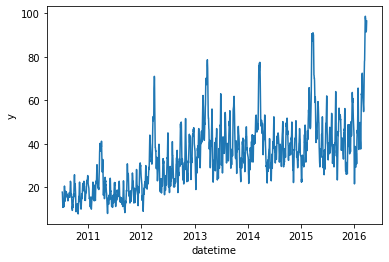

In [81]:
roll = train['y'].rolling(5).mean()
sns.lineplot(x=train["datetime"],y=roll)

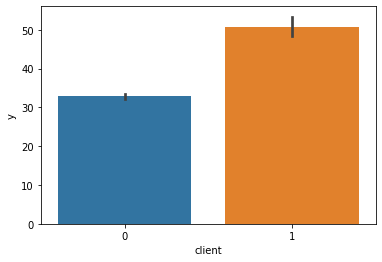

In [82]:
#法人の方が多い
sns.barplot(x=train["client"],y=train["y"],data=train)


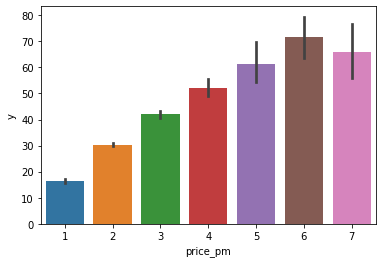

In [83]:
sns.barplot(x=train["price_pm"],y=train["y"],data=train)

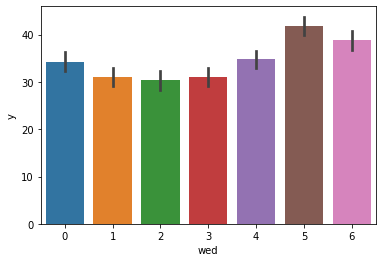

In [84]:
#月→０、日→６
sns.barplot(x=train["wed"],y=train["y"],data=train)

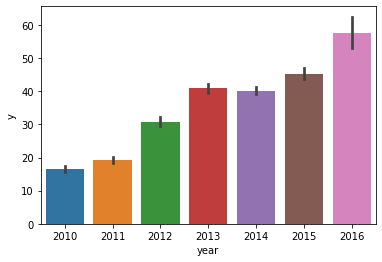

In [85]:
sns.barplot(x=train["year"],y=train["y"],data=train)

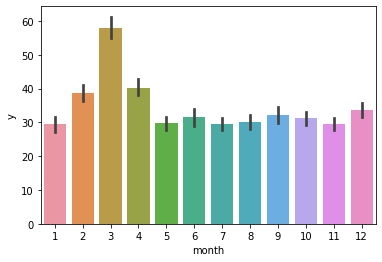

In [86]:
sns.barplot(x=train["month"],y=train["y"],data=train)

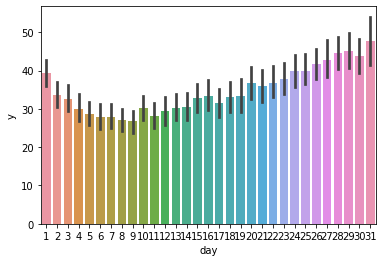

In [87]:
sns.barplot(x=train["day"],y=train["y"],data=train)

In [88]:

# sns.barplot(x=train["shukujitu"],y=train["y"],data=train)

In [89]:
#時系列分析
data = train[['datetime','y']]
data = data.rename(columns={"datetime":"ds"})
m = Prophet()
m.fit(data)
future = m.make_future_dataframe(periods=len(test),freq='D')
future

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
0,2010-07-01
1,2010-07-02
2,2010-07-03
3,2010-07-04
4,2010-07-05
...,...
2432,2017-03-27
2433,2017-03-28
2434,2017-03-29
2435,2017-03-30


In [90]:
predict = m.predict(future)
# predict.head()
# fig1 = m.plot(predict)
pred_proh = predict[2101:]

In [91]:
train = train.fillna(0)
test  = test.fillna(0)
test.shape

(365, 23)

In [92]:
train.dtypes
del train["datetime"]
del test["datetime"]
y_train = train["y"]
# y_train = np.log1p(y_train)
del train["y"]
X_train = train


In [93]:
params = {
    "metrics": "mae",
    "learning_rate":0.07,
    "n_estimator":200,
    "num_iterations":800,
    "max_depth":6
}
#cv:0.07,200,800,6→９.０８

In [94]:


#CV
def tscv(model,train_x,train_y,splits):
    tss = TimeSeriesSplit(n_splits=splits)
    scores = []
    for tr_idx,val_idx in tss.split(X_train):
        tr_x,va_x =train_x.iloc[tr_idx],train_x.iloc[val_idx]
        tr_y,va_y =train_y.iloc[tr_idx],train_y.iloc[val_idx]
        model.fit(tr_x,tr_y)
        pred_y = model.predict(va_x)
        score = mae(va_y,pred_y)
        scores.append(score)
        print(score)
    print("cv:",np.mean(scores))

model_lgbm = lgb.LGBMRegressor(**params,random_state=111)
tscv(model_lgbm,X_train,y_train,4)



9.944872068804958
11.457400482760034
6.147245537984924
8.862604697006889
cv: 9.1030306966392


In [95]:
params_cat = {
    'max_depth' : 5,                  # 木の深さ
    'learning_rate' : 0.07,       # 学習率
    'early_stopping_rounds' : 10,
    'iterations' : 500, 
    "eval_metric":"MAE", 
    'random_seed' :111
}
cat = CatBoostRegressor(**params_cat)
tscv(cat,X_train,y_train,4)

0:	learn: 5.6972038	total: 850us	remaining: 424ms
1:	learn: 5.5585947	total: 1.22ms	remaining: 303ms
2:	learn: 5.3856488	total: 1.75ms	remaining: 290ms
3:	learn: 5.2394546	total: 2.31ms	remaining: 287ms
4:	learn: 5.1073778	total: 2.86ms	remaining: 283ms
5:	learn: 5.0306719	total: 3.38ms	remaining: 278ms
6:	learn: 4.9234826	total: 4.06ms	remaining: 286ms
7:	learn: 4.8264934	total: 4.6ms	remaining: 283ms
8:	learn: 4.7368924	total: 5.16ms	remaining: 281ms
9:	learn: 4.6383659	total: 5.71ms	remaining: 280ms
10:	learn: 4.5286287	total: 6.23ms	remaining: 277ms
11:	learn: 4.4425527	total: 7.11ms	remaining: 289ms
12:	learn: 4.3557699	total: 8.27ms	remaining: 310ms
13:	learn: 4.2885541	total: 10.3ms	remaining: 358ms
14:	learn: 4.2174915	total: 10.8ms	remaining: 351ms
15:	learn: 4.1464878	total: 11.4ms	remaining: 344ms
16:	learn: 4.0901119	total: 12ms	remaining: 340ms
17:	learn: 4.0262969	total: 12.9ms	remaining: 345ms
18:	learn: 3.9717491	total: 13.8ms	remaining: 350ms
19:	learn: 3.9142130	total

In [96]:
# model = lgb.LGBMRegressor(**params,random_state=111)
# model.fit(X_train,y_train)
cat = CatBoostRegressor(**params_cat)
cat.fit(X_train,y_train)
# pred_y = (model.predict(test)+cat.predict(test))/2
pred_y = cat.predict(test)

test["y"] = pred_y
test["y"] = test["y"].mask(test["close"]==1,0)

0:	learn: 12.9628700	total: 811us	remaining: 405ms
1:	learn: 12.4311995	total: 2.14ms	remaining: 534ms
2:	learn: 11.9176673	total: 3.04ms	remaining: 503ms
3:	learn: 11.4519429	total: 3.92ms	remaining: 487ms
4:	learn: 10.9839732	total: 4.76ms	remaining: 472ms
5:	learn: 10.5636738	total: 5.65ms	remaining: 465ms
6:	learn: 10.2267022	total: 6.5ms	remaining: 458ms
7:	learn: 9.8857801	total: 7.22ms	remaining: 444ms
8:	learn: 9.5334161	total: 8.99ms	remaining: 490ms
9:	learn: 9.2091856	total: 9.74ms	remaining: 477ms
10:	learn: 8.9499976	total: 10.6ms	remaining: 470ms
11:	learn: 8.6895789	total: 11.4ms	remaining: 464ms
12:	learn: 8.4524333	total: 12.2ms	remaining: 459ms
13:	learn: 8.2423826	total: 13.1ms	remaining: 455ms
14:	learn: 8.0283738	total: 14ms	remaining: 451ms
15:	learn: 7.8444191	total: 18.4ms	remaining: 557ms
16:	learn: 7.6657928	total: 19.3ms	remaining: 549ms
17:	learn: 7.4919463	total: 20.8ms	remaining: 557ms
18:	learn: 7.3372108	total: 21.6ms	remaining: 547ms
19:	learn: 7.207054

In [97]:
# model.plot_importance(model, height = 0.5, figsize = (8,8))

In [98]:
sub = pd.read_csv("sample_submit_hikkoshi.csv",header=None)
# sub[1] = np.expm1(test["y"])
sub[1] = test["y"]

sub.to_csv("submit.csv",header=None,index=None)


In [99]:
# del test["y"]

In [100]:
#予測結果を真として学習データに組み込むver

new_train = pd.concat([train,y_train],axis=1)
all = pd.concat([new_train,test]).reset_index()
del all["index"]
y_all = all["y"]
x_all = all

cat = CatBoostRegressor(**params_cat)
tscv(cat,x_all,y_all,4)

0:	learn: 5.4599746	total: 598us	remaining: 299ms
1:	learn: 5.1498531	total: 1.78ms	remaining: 443ms
2:	learn: 4.8451016	total: 2.99ms	remaining: 495ms
3:	learn: 4.5772311	total: 3.55ms	remaining: 440ms
4:	learn: 4.2924821	total: 4.04ms	remaining: 400ms
5:	learn: 4.0655543	total: 6.19ms	remaining: 510ms
6:	learn: 3.8156656	total: 7.52ms	remaining: 530ms
7:	learn: 3.6031169	total: 8.1ms	remaining: 498ms
8:	learn: 3.3933144	total: 8.93ms	remaining: 487ms
9:	learn: 3.2280158	total: 9.76ms	remaining: 478ms
10:	learn: 3.0694404	total: 10.6ms	remaining: 471ms
11:	learn: 2.8905601	total: 11.4ms	remaining: 464ms
12:	learn: 2.7861253	total: 12ms	remaining: 451ms
13:	learn: 2.6482548	total: 12.6ms	remaining: 436ms
14:	learn: 2.4890863	total: 13.2ms	remaining: 426ms
15:	learn: 2.3468514	total: 13.8ms	remaining: 417ms
16:	learn: 2.2275081	total: 14.3ms	remaining: 407ms
17:	learn: 2.1232792	total: 14.9ms	remaining: 399ms
18:	learn: 1.9938366	total: 15.5ms	remaining: 393ms
19:	learn: 1.8928975	total

In [101]:
cat.fit(x_all,y_all)
new_pred_y = cat.predict(test)
test["y"] = new_pred_y
test["y"] = test["y"].mask(test["close"]==1,0)

new_sub = pd.read_csv("sample_submit_hikkoshi.csv",header=None)
# sub[1] = np.expm1(test["y"])
# new_sub[1] = 0.8*test["y"]+0.2*pred_proh.reset_index()["yhat"] #LB大幅ダウン
new_sub[1] = test["y"]
new_sub.to_csv("submit_allver.csv",header=None,index=None)

0:	learn: 13.1148090	total: 1.1ms	remaining: 551ms
1:	learn: 12.2281647	total: 2.56ms	remaining: 638ms
2:	learn: 11.4295596	total: 3.45ms	remaining: 572ms
3:	learn: 10.6975914	total: 4.54ms	remaining: 563ms
4:	learn: 10.0341851	total: 5.47ms	remaining: 541ms
5:	learn: 9.4424462	total: 6.55ms	remaining: 539ms
6:	learn: 8.8981101	total: 7.62ms	remaining: 537ms
7:	learn: 8.3523085	total: 8.55ms	remaining: 526ms
8:	learn: 7.8228459	total: 9.62ms	remaining: 525ms
9:	learn: 7.3612320	total: 10.7ms	remaining: 523ms
10:	learn: 6.8675856	total: 11.8ms	remaining: 524ms
11:	learn: 6.4411411	total: 12.8ms	remaining: 523ms
12:	learn: 6.0862974	total: 13.9ms	remaining: 521ms
13:	learn: 5.6852691	total: 15ms	remaining: 520ms
14:	learn: 5.3182786	total: 16.1ms	remaining: 520ms
15:	learn: 4.9800175	total: 17.1ms	remaining: 518ms
16:	learn: 4.6634720	total: 18.2ms	remaining: 518ms
17:	learn: 4.4065405	total: 19.3ms	remaining: 516ms
18:	learn: 4.1223007	total: 20.3ms	remaining: 515ms
19:	learn: 3.8859772